In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection, linear_model, metrics
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [2]:
df_train = pd.read_csv("../data/train_new.csv", sep="|")
df_val = pd.read_csv("../data/val_new.csv", sep="|")
df_train['totalScannedLineItems'] = df_train['scannedLineItemsPerSecond'] * df_train['totalScanTimeInSeconds']
df_val['totalScannedLineItems'] = df_val['scannedLineItemsPerSecond'] * df_val['totalScanTimeInSeconds']
y_train = df_train.fraud
X_train = df_train.drop(['fraud'], axis=1)
y_val = df_val.fraud
X_val = df_val.drop(['fraud'], axis=1)
df_train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud,totalScannedLineItems
0,4,828,66.56,7,4,3,0.007246,0.080386,1.166667,0,6.0
1,1,1612,31.34,2,4,3,0.008685,0.019442,0.142857,0,14.0
2,3,848,52.37,2,4,0,0.022406,0.061757,0.105263,0,19.0
3,1,321,76.03,8,7,2,0.071651,0.236854,0.347826,0,23.0
4,1,660,6.06,3,7,1,0.027273,0.009182,0.166667,0,18.0


In [3]:
def score_function(y_test, y_pred):
  # return metrics.accuracy_score(y_test, y_pred)
  return (0 if all(y_pred == 0) else metrics.fbeta_score(y_test, y_pred, beta=2),
          np.sum(metrics.confusion_matrix(y_test, y_pred)*np.array([[0, -25],[ -5, 5]])), #sklearn gives [[tn,fp],[fn,tp]]
          metrics.confusion_matrix(y_test, y_pred).tolist(),
          dmc_score_function(y_test, y_pred))
  # return metrics.f1_score(y_test, y_pred)


def dmc_score_function(y_true, y_pred):
    loss = 0.0
    for index, item in enumerate(y_true):
        if y_true[index] == 0:
            if y_pred[index] == 0:
                loss += 0.0
            else:
                loss -= 25.0
        else:
            if y_pred[index] == 0:
                loss -= 5.0
            else:
                loss += 5.0
    return loss


def get_accuracy(classifier):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_val)
    return score_function(y_val, y_pred)

## Comparison between a few Classifiers with default values

In [14]:
names = ["KNN (K=3)", "Linear SVM", "RBF SVM", "Gaus. Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "Quadr.Dis.A."]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
]

# iterate over classifiers
for name, clf in zip(names, classifiers):
    print(name, "\t\t", get_accuracy(clf))

KNN (K=3) 		 (0.0, -340, [[344, 9], [23, 0]], -340.0)
Linear SVM 		 (0.7727272727272728, 30, [[352, 1], [6, 17]], 30.0)
RBF SVM 		 (0, -115, [[353, 0], [23, 0]], -115.0)
Gaus. Process 		 (0.09615384615384613, -345, [[343, 10], [21, 2]], -345.0)
Decision Tree 		 (0.5963302752293578, -85, [[349, 4], [10, 13]], -85.0)
Random Forest 		 (0.15789473684210528, -85, [[353, 0], [20, 3]], -85.0)
Neural Net 		 (0.6818181818181819, -40, [[350, 3], [8, 15]], -40.0)
AdaBoost 		 (0.8035714285714285, 15, [[351, 2], [5, 18]], 15.0)
Naive Bayes 		 (0.7291666666666666, -680, [[322, 31], [2, 21]], -680.0)
Quadr.Dis.A. 		 (0.7664233576642336, -505, [[329, 24], [2, 21]], -505.0)


GradBoost 	 (0.7964601769911505, -10, [[350, 3], [5, 18]], -10.0)
AdaBoost 	 (0.8771929824561403, 35, [[351, 2], [3, 20]], 35.0)
XGBoost 	 (0.7657657657657656, 5, [[351, 2], [6, 17]], 5.0)


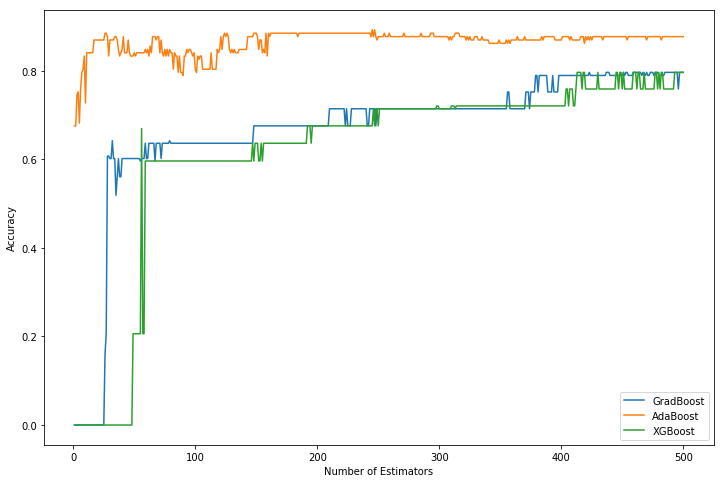

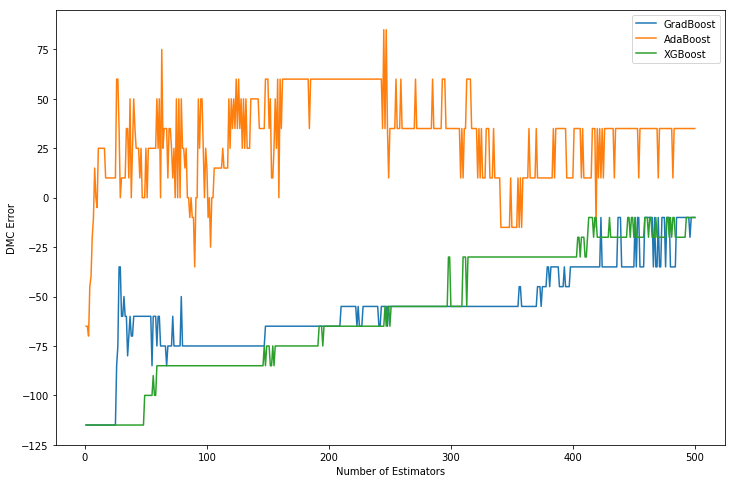

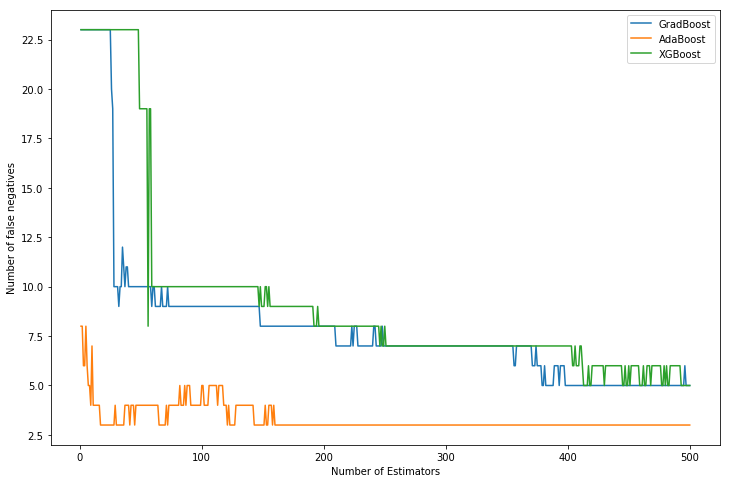

In [16]:
n_estimators=500

# plot the accuracy after each boosting iteration
def get_accuracy_for_n_estimators(classifier):
    accuracy = []
    if (isinstance(classifier, XGBClassifier)):
        for i in range(n_estimators):
            classifier = XGBClassifier(n_estimators=i, random_state=1, max_depth=1)
            classifier.fit(X_train, y_train)
            accuracy.append(score_function(y_val, classifier.predict(X_val)))
    else:
        for i, y_pred in enumerate(classifier.staged_predict(X_val)):
            accuracy.append(score_function(y_val, y_pred))
    return accuracy

 
# GradBoost
classifier_gdb = GradientBoostingClassifier(n_estimators=n_estimators, random_state=1, max_depth=1)
print("GradBoost", "\t", get_accuracy(classifier_gdb) )
accuracy_gdb = get_accuracy_for_n_estimators(classifier_gdb)

# AdaBoost
classifier_adb = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=n_estimators, algorithm='SAMME', random_state=1)
print("AdaBoost", "\t", get_accuracy(classifier_adb) )
accuracy_adb = get_accuracy_for_n_estimators(classifier_adb)

# XGBoost
classifier_xgb = XGBClassifier(e_estimators=n_estimators, random_state=1, max_depth=3)
print("XGBoost", "\t", get_accuracy(classifier_xgb) )
accuracy_xgb = get_accuracy_for_n_estimators(classifier_xgb)

# Plot for each number of estimators
plt.figure(figsize=(12, 8))    
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.plot(np.arange(n_estimators) + 1, list(zip(*accuracy_gdb))[0], label="GradBoost")
plt.plot(np.arange(n_estimators) + 1, list(zip(*accuracy_adb))[0], label="AdaBoost")
plt.plot(np.arange(n_estimators) + 1, list(zip(*accuracy_xgb))[0], label="XGBoost")
plt.legend()
plt.show()

# Plot for each number of estimators
plt.figure(figsize=(12, 8))    
plt.xlabel('Number of Estimators')
plt.ylabel('DMC Error')
plt.plot(np.arange(n_estimators) + 1, list(zip(*accuracy_gdb))[1], label="GradBoost")
plt.plot(np.arange(n_estimators) + 1, list(zip(*accuracy_adb))[1], label="AdaBoost")
plt.plot(np.arange(n_estimators) + 1, list(zip(*accuracy_xgb))[1], label="XGBoost")
plt.legend()
plt.show()

# Plot for each number of estimators
plt.figure(figsize=(12, 8))    
plt.xlabel('Number of Estimators')
plt.ylabel('Number of false negatives')
plt.plot(np.arange(n_estimators) + 1, list(zip(*list(zip(*list(zip(*accuracy_gdb))[2]))[1]))[0], label="GradBoost")
plt.plot(np.arange(n_estimators) + 1, list(zip(*list(zip(*list(zip(*accuracy_adb))[2]))[1]))[0], label="AdaBoost")
plt.plot(np.arange(n_estimators) + 1, list(zip(*list(zip(*list(zip(*accuracy_xgb))[2]))[1]))[0], label="XGBoost")
plt.legend()
plt.show()

In [17]:
best_n_estimators = np.argmax(list(zip(*accuracy_adb))[0])+1 # get index of best accuracy
print(best_n_estimators) #todo crossvalidation to get best n_estimator

# AdaBoost
classifier_adb = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=best_n_estimators, algorithm='SAMME', random_state=1)
print("AdaBoost", "\t", get_accuracy(classifier_adb) )

245
AdaBoost 	 (0.8928571428571428, 85, [[353, 0], [3, 20]], 85.0)


## Automatic paramter search by SkLearn

In [4]:
from scipy.stats import uniform, randint
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from xgboost import XGBClassifier

In [5]:
# Defining a model with a "random state" for reproducablity and with a loss for binary classification
xgb_model = XGBClassifier(nthread=8, objective="binary:logistic", random_state=42,eval_metric="auc")
# Defining the paramters and the range in which they should be optimized
params = {
    "eta": uniform(0.1, 0.7),
    "gamma": uniform(0, 1),
    "max_depth": randint(2, 8),  # default 3
    "n_estimators": randint(100, 400),  # default 100
    "colsample_bytree" : uniform(0.1,0.9)
}
""" Some more paramters, but because of runtime I use here only 5 
    "subsample": uniform(0.6, 0.4),
    "lambda" : uniform(1e-3, 1),
    "learning_rate": uniform(0.03, 0.3),  # default 0.1

"""

' Some more paramters, but because of runtime I use here only 5 \n    "subsample": uniform(0.6, 0.4),\n    "lambda" : uniform(1e-3, 1),\n    "learning_rate": uniform(0.03, 0.3),  # default 0.1\n\n'

### Util functions to display best parameters

In [6]:
def display_scores(scores):
    print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))



def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [9]:
ftwo_scorer = metrics.make_scorer(metrics.fbeta_score, beta=3)
search = RandomizedSearchCV(xgb_model, scoring=ftwo_scorer, param_distributions=params, random_state=42, n_iter=200,
                            cv=3, verbose=1, n_jobs=12, return_train_score=True)
search.fit(X_train, y_train)

report_best_scores(search.cv_results_, 3)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   21.3s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  1.1min
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:  2.5min
[Parallel(n_jobs=12)]: Done 600 out of 600 | elapsed:  3.3min finished


Model with rank: 1
Mean validation score: 0.834 (std: 0.041)
Parameters: {'colsample_bytree': 0.8650347200108194, 'eta': 0.4146154718967423, 'gamma': 0.09541011649041131, 'max_depth': 7, 'n_estimators': 315}

Model with rank: 2
Mean validation score: 0.834 (std: 0.059)
Parameters: {'colsample_bytree': 0.87084085706949, 'eta': 0.5610855421332615, 'gamma': 0.1629344270814297, 'max_depth': 3, 'n_estimators': 259}

Model with rank: 2
Mean validation score: 0.834 (std: 0.059)
Parameters: {'colsample_bytree': 0.8124211393532637, 'eta': 0.6527326999561877, 'gamma': 0.09120610304869037, 'max_depth': 3, 'n_estimators': 285}

Model with rank: 2
Mean validation score: 0.834 (std: 0.059)
Parameters: {'colsample_bytree': 0.8024461367914789, 'eta': 0.2943110208405927, 'gamma': 0.22009721408109706, 'max_depth': 3, 'n_estimators': 148}

